In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Loading the LoadCNNModel.py in colab environment that contains the model definitions
!cp /content/drive/My\ Drive/LoadCNNModel.py /content

Importing Modules

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
import zipfile
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm, tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from LoadCNNModel import loadRestNetModel

In [ ]:
#To check if GPU is enables
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
BASE_PATH = '/content'
#Function for extracting dataset
def extract_dataset(path):
 

  zip_ref = zipfile.ZipFile(path, 'r')
  zip_ref.extractall(BASE_PATH)
  zip_ref.close()

In [ ]:
#Extracting the dataset
extract_dataset('/content/drive/My Drive/Research_Dataset/Dataset.zip')

In [ ]:
#Loading the train, test and validation image labels
train = pd.read_csv('/content/Dataset/train.csv')
test = pd.read_csv('/content/Dataset/test.csv')
val = pd.read_csv('/content/Dataset/val.csv')

In [ ]:
test.head()

,Image,CancerType,lung_aca,lung_n,lung_scc
0,lungaca1295.jpeg,lung_aca,1,0,0
1,lungaca249.jpeg,lung_aca,1,0,0
2,lungscc2058.jpeg,lung_scc,0,0,1
3,lungn4006.jpeg,lung_n,0,1,0
4,lungn3434.jpeg,lung_n,0,1,0


In [ ]:
'''
Image Data Generator for loading the images for Train, Test and Validation Images 

1. flow_from_dataframe() : loads the images listed in the dataframe loaded in the previous step
by extracting the image name mentioned in "x_col" and the labels are in the "y_col"
the path for the images are set in the "directory" argument.

2. The real time augmentation are specified in the ImageDataGenerator object created for training "dataGenerator".
'''
image_size = 224

dataGenerator = ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rotation_range=45,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range=[0.3,0.6],
                                fill_mode='nearest',
                                shear_range=0.1,
                                rescale=1/255,
                                )#validation_split=0.2

test_Data_Generator = ImageDataGenerator(rescale=1/255)                                
trainGenerator = dataGenerator.flow_from_dataframe(train,
                                        directory='/content/Dataset/Train',
                                        target_size=(image_size, image_size),
                                        x_col="Image",
                                        y_col=['lung_aca','lung_n','lung_scc'],
                                        class_mode='raw',
                                        shuffle=False,
                                        subset='training',
                                        batch_size=32)
validGenerator =  test_Data_Generator.flow_from_dataframe(val,
                                        directory='/content/Dataset/Val',
                                        target_size=(image_size,image_size),
                                        x_col="Image",
                                        y_col=['lung_aca','lung_n','lung_scc'],
                                        class_mode='raw',
                                        shuffle=False,
                                        batch_size=32)
test_gen = test_Data_Generator.flow_from_dataframe(test,
                                        directory='/content/Dataset/Test',
                                        target_size=(image_size,image_size),
                                        x_col="Image",
                                        y_col=['lung_aca','lung_n','lung_scc'],
                                        class_mode='raw',
                                        shuffle=False,
                                        batch_size=32)


In [ ]:
#Initializing the RestNet50 model
model = loadRestNetModel((224,224,3),3)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
#Printing the model summary
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
#Initilizing the optimizer 
adam = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])

In [ ]:
#Initializing the callbacks
log = CSVLogger('RestNet50.csv')
lr_decay = LearningRateScheduler(schedule=lambda epoch: 0.0001 * np.exp(-epoch / 10.))
mc = ModelCheckpoint('./drive/My Drive/rp_resnet50_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
#Training the RestNet model
train_step = trainGenerator.n//trainGenerator.batch_size
val_step = validGenerator.n//validGenerator.batch_size
history = model.fit_generator(generator=trainGenerator,
                                steps_per_epoch=train_step,
                                validation_data=validGenerator,
                                validation_steps=val_step,
                                epochs=30,callbacks=[log, mc])



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
299/299 [==============================] - ETA: 0s - loss: 0.9240 - accuracy: 0.6518
Epoch 00001: val_accuracy improved from -inf to 0.79125, saving model to /content/drive/My Drive/Research_Dataset/ResNet50/resnet50_model.h5
299/299 [==============================] - 158s 530ms/step - loss: 0.9240 - accuracy: 0.6518 - val_loss: 0.5355 - val_accuracy: 0.7912
Epoch 2/30
299/299 [==============================] - ETA: 0s - loss: 0.5558 - accuracy: 0.7783
Epoch 00002: val_accuracy improved from 0.79125 to 0.83917, saving model to /content/drive/My Drive/Research_Dataset/ResNet50/resnet50_model.h5
299/299 [==============================] - 163s 545ms/step - loss: 0.5558 - accuracy: 0.7783 - val_loss: 0.4597 - val_accuracy: 0.8392
Epoch 3/30
299/299 [==============================] - ETA: 0s - loss: 0.4878 - accuracy: 0.8091
Epoch 00003: val_accuracy improved from 0.83917 to 0.86125, saving model to /cont

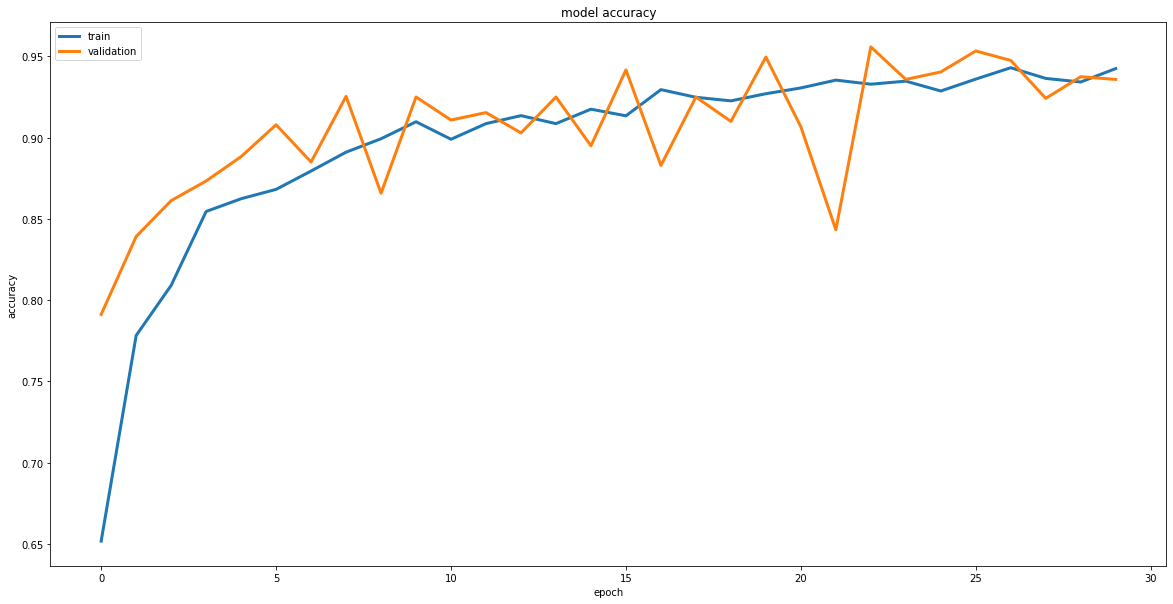

In [ ]:
#Plotting the train and validation accuracy curve
plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'],linewidth=3.0)
plt.plot(history.history['val_accuracy'],linewidth=3.0)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

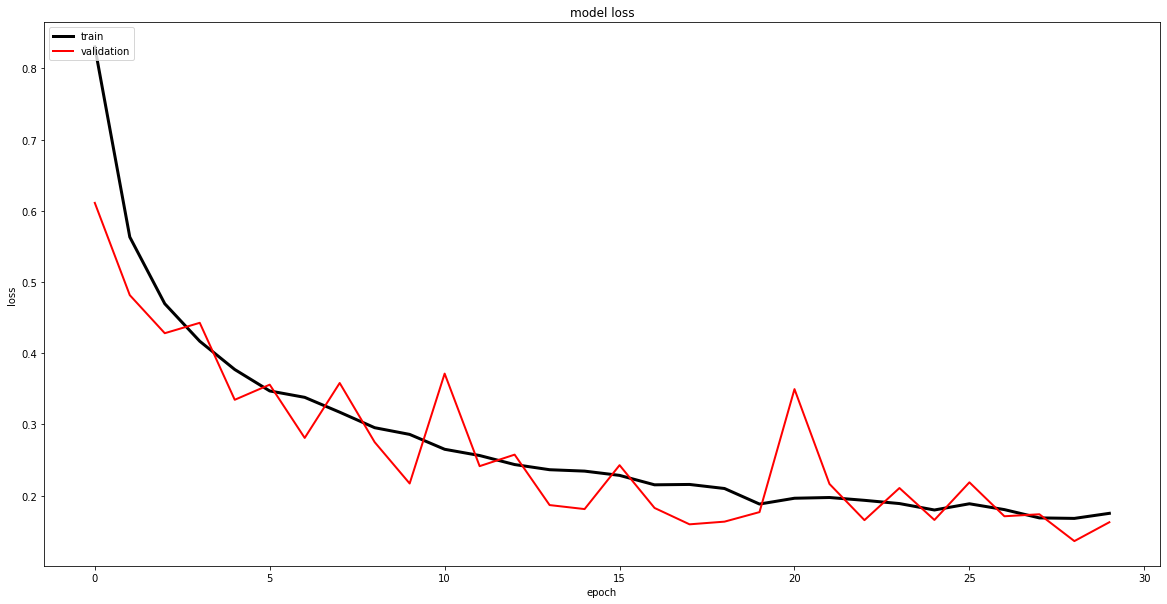

In [ ]:
#Plotting the training and validation loss curve
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], color='black',linewidth=3.0)
plt.plot(history.history['val_loss'],color='red',linewidth=2.0)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#Loading the model for evaluation
from keras.models import  load_model
model = load_model('/content/drive/My Drive/rp_resnet50_model.h5')

In [ ]:
#Evaluating the test accuracy
test_pred = model.evaluate_generator(test_gen,verbose=1)
print("Testing Accuracy :"+str(test_pred[1])+" Testing loss : "+str(test_pred[0]))

Instructions for updating:
Please use Model.evaluate, which supports generators.
94/94 [==============================] - 17s 178ms/step - loss: 0.1293 - accuracy: 0.9550
Testing Accuracy :0.9549999833106995 Testing loss : 0.12926195561885834


In [ ]:
#Extracting the prediction made by the model
testin_predictions = model.predict(test_gen,verbose=1)
testin_predictions[0]

94/94 [==============================] - 17s 176ms/step


array([0.9622903 , 0.02615528, 0.01155445], dtype=float32)

In [ ]:
testin_predictionsb = (testin_predictions>0.5)
testin_predictionsb[0]

array([ True, False, False])

### Converting the prediction into string labels

The predictions are converted from label encodings to actual string labels.
"result" dataframe is created which has the predictied values


In [ ]:
predictions = testin_predictionsb.astype(int)

In [ ]:
columns = ['lung_aca', 'lung_n', 'lung_scc']

results = pd.DataFrame(predictions, columns=columns)
results['Image'] = test_gen.filenames
ordered_cols = ['Image'] + columns
results = results[ordered_cols]
results.head()

,Image,lung_aca,lung_n,lung_scc
0,lungaca1295.jpeg,1,0,0
1,lungaca249.jpeg,1,0,0
2,lungscc2058.jpeg,0,0,1
3,lungn4006.jpeg,0,1,0
4,lungn3434.jpeg,0,1,0


In [ ]:
'''
The "Predicted_CancerType" column of the "result" dataframe contains the
predicted cancer type.
'''
results['Image'] = test_gen.filenames
results.insert(4,'Predicted_CancerType', '', False)
ordered_cols = ['Image'] + columns + ['Predicted_CancerType']
results = results[ordered_cols]

for i in range(len(results)):
  if results.at[i,'lung_aca'] == 1:
    results.at[i,'Predicted_CancerType'] = 'lung_aca'
  elif results.at[i,'lung_n'] == 1:
    results.at[i,'Predicted_CancerType'] = 'lung_n'
  else:
    results.at[i,'Predicted_CancerType'] = 'lung_scc'

results.head()

,Image,lung_aca,lung_n,lung_scc,Predicted_CancerType
0,lungaca1295.jpeg,1,0,0,lung_aca
1,lungaca249.jpeg,1,0,0,lung_aca
2,lungscc2058.jpeg,0,0,1,lung_scc
3,lungn4006.jpeg,0,1,0,lung_n
4,lungn3434.jpeg,0,1,0,lung_n


In [ ]:
#Estimation of the Matthew's Correlation Coefficient
mcc = metrics.matthews_corrcoef(test['CancerType'], results['Predicted_CancerType'])
print("Matthews Correlation Coefficient: ", mcc)

Matthews Correlation Coefficient:  0.9323720733663772


In [ ]:
#Estimation of the F1 Score
print(metrics.classification_report(test['CancerType'], results['Predicted_CancerType'],columns))

              precision    recall  f1-score   support

    lung_aca       0.95      0.97      0.96       980
      lung_n       0.97      0.92      0.94      1017
    lung_scc       0.95      0.98      0.96      1003

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.96      0.95      0.95      3000



In [ ]:
#Generating the confusion matrix
confusion_mtx = metrics.confusion_matrix(test['CancerType'], results['Predicted_CancerType'],columns)
confusion_mtx.T

array([[947,  44,   7],
       [ 17, 933,  12],
       [ 16,  40, 984]])

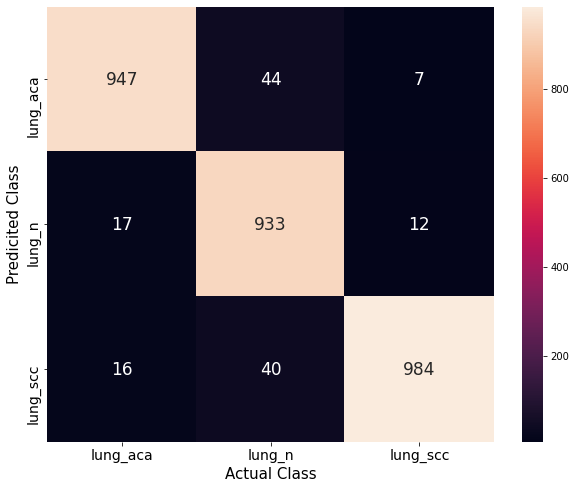

In [ ]:
#plotting the confusion matrix
plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(confusion_mtx.T, annot=True, ax = ax,fmt='g',annot_kws={"size": 17})
ax.xaxis.set_ticklabels(columns)
ax.yaxis.set_ticklabels(columns)
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
ax.set_xlabel('Actual Class')
ax.set_ylabel('Predicited Class')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()